In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def rank_feature_importance(X, y):
    S = list(X.columns)
    R = []

    while S:
        model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
        model.fit(X[S], y)

        importances = model.feature_importances_
        y_pred = model.oob_prediction_
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        R.append({
            'Features': S.copy(),
            'RMSE': rmse,
            'R2': r2,
            'Least Important Feature': None
        })

        least_important_feature = S[np.argmin(importances)]
        S.remove(least_important_feature)

        R[-1]['Least Important Feature'] = least_important_feature

    return pd.DataFrame(R)

def dummy_plot_predictor_importance(ranking_table, title, num_observations, ax, manual_dividing_line=False, keep_features=6):
    if manual_dividing_line:
        dividing_point = len(ranking_table) - keep_features
    else:
        dividing_point = None
        threshold = 0.005
        for i in range(1, len(ranking_table)):
            rmse_change = (ranking_table.loc[i, 'RMSE'] - ranking_table.loc[i-1, 'RMSE']) / ranking_table.loc[i-1, 'RMSE']
            r2_change = (ranking_table.loc[i-1, 'R2'] - ranking_table.loc[i, 'R2']) / ranking_table.loc[i-1, 'R2']
            if rmse_change > threshold and r2_change > threshold:
                dividing_point = i - 1
                break

    if dividing_point is not None:
        important_features = ranking_table.loc[dividing_point + 1:, 'Least Important Feature'].tolist()
        return important_features
    else:
        return []

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att": "FSO_Att",
        "RFL_Att": "RFL_Att",
        "AbsoluteHumidity": "AH",
        "AbsoluteHumidityMax": "AH_Max",
        "AbsoluteHumidityMin": "AH_Min",
        "Distance": "Dist",
        "Frequency": "Freq",
        "Particulate": "Part",
        "ParticulateMax": "Part_Max",
        "ParticulateMin": "Part_Min",
        "RainIntensity": "RainInt",
        "RainIntensityMax": "RainInt_Max",
        "RainIntensityMin": "RainInt_Min",
        "RelativeHumidity": "RH",
        "SYNOPCode": "SYNOPCode",
        "Temperature": "Temp",
        "TemperatureDifference": "TDiff",
        "TemperatureMax": "Temp_Max",
        "TemperatureMin": "Temp_Min",
        "Time": "Time",
        "Visibility": "Visi",
        "VisibilityMax": "Visi_Max",
        "VisibilityMin": "Visi_Min",
        "WindDirection": "WD",
        "WindSpeed": "WS",
        "WindSpeedMax": "WS_Max",
        "WindSpeedMin": "WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
from google.colab import drive
drive.mount('/content/drive')

data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train, X_temp, y_train_fso, y_temp_fso, y_train_rfl, y_temp_rfl = train_test_split(X, y_fso, y_rfl, test_size=0.3, random_state=42)
X_val, X_test, y_val_fso, y_test_fso, y_val_rfl, y_test_rfl = train_test_split(X_temp, y_temp_fso, y_temp_rfl, test_size=0.5, random_state=42)

# Exclude 'Freq' from the FSO dataset
X_train_fso = X_train.drop(columns=['Freq'])
X_val_fso = X_val.drop(columns=['Freq'])
X_test_fso = X_test.drop(columns=['Freq'])

# For FSO Attenuation
results_fso = rank_feature_importance(X_train_fso, y_train_fso)
important_features_fso = dummy_plot_predictor_importance(results_fso, 'FSO Attenuation: Generic', len(X_train_fso), None, manual_dividing_line=False)

def train_model(x_train, y_train, important_features):
    x_train = x_train[important_features]
    model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
    model.fit(x_train, y_train)
    return model

def get_predictions_and_metrics(x_test, y_test, model, important_features):
    x_test = x_test[important_features]
    predictions = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return predictions, rmse, r2

# Train models using the important predictors
model_fso = train_model(X_train_fso, y_train_fso, important_features_fso)

#Add predicted FSO attenuations to the training set
predictions_train_fso, _, _ = get_predictions_and_metrics(X_train_fso, y_train_fso, model_fso, important_features_fso)
X_train_with_fso = X_train.copy()
X_train_with_fso['Predicted_FSO_Att'] = predictions_train_fso

# FSO Attenuation: Joint with Predicted_RFL_Att
results_rfl_method3 = rank_feature_importance(X_train_with_fso, y_train_rfl)
important_features_rfl_method3 = dummy_plot_predictor_importance(results_rfl_method3, 'RFL Attenuation: Joint', len(X_train_with_fso), None, manual_dividing_line=False)

# Train FSO model using Predicted RFL attenuations
model_rfl_method3 = train_model(X_train_with_fso, y_train_rfl, important_features_rfl_method3)

# Generate predictions for RFL
predictions_test_fso, rmse_fso_method3, r2_fso_method3  = get_predictions_and_metrics(X_test_fso, y_test_fso, model_fso, important_features_fso)
X_test_with_fso = X_test.copy()
X_test_with_fso['Predicted_FSO_Att'] = predictions_test_fso

# Generate and evaluate predictions for RFL
predictions_rfl_method3, rmse_rfl_method3, r2_rfl_method3 = get_predictions_and_metrics(X_test_with_fso, y_test_rfl, model_rfl_method3, important_features_rfl_method3)

# Print the evaluation metrics for FSO attenuation predictions
print(f"RFL Attenuation method3 RMSE: {rmse_rfl_method3}")
print(f"RFL Attenuation method3 R²: {r2_rfl_method3}")
print(f"FSO Attenuation method3 RMSE: {rmse_fso_method3}")
print(f"FSO Attenuation method3 R²: {r2_fso_method3}")

Found GPU at: 
Mounted at /content/drive
RFL Attenuation method3 RMSE: 0.765954976271114
RFL Attenuation method3 R²: 0.9499812697844071
FSO Attenuation method3 RMSE: 0.9936389930879125
FSO Attenuation method3 R²: 0.933684728722319


In [2]:
from scipy.stats import entropy, pearsonr
from sklearn.metrics import mutual_info_score

test_rfl_subsets_method3 = {}
test_fso_subsets_method3 = {}

synop_codes_order = [0, 3, 4, 5, 6, 7, 8]

# Weather condition mapping
synopcode_to_weather = {
    0: 'Clear Weather',
    3: 'Dust storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

# Prepare results storage for predicted data
M3_results_1 = {
    "Weather": [],
    "rEO": [],
    "HE": [],
    "HO": [],
    "HEO": [],
    "IEO": [],
    "IEO/HEO": []
}

M3_results_2 = {
    "Weather": [],
    "rEO": [],
    "HE": [],
    "HO": [],
    "HEO": [],
    "IEO": [],
    "IEO/HEO": []
}

def calculate_entropy(data, bin_size):
    counts, _ = np.histogram(data, bins=np.arange(min(data), max(data) + bin_size, bin_size))
    probabilities = counts / np.sum(counts)
    return entropy(probabilities, base=2)

# Function to calculate joint entropy
def calculate_joint_entropy(data1, data2, bin_size):
    joint_counts, _, _ = np.histogram2d(data1, data2, bins=[np.arange(min(data1), max(data1) + bin_size, bin_size),
                                                              np.arange(min(data2), max(data2) + bin_size, bin_size)])
    joint_probabilities = joint_counts / np.sum(joint_counts)
    return entropy(joint_probabilities.flatten(), base=2)

# Function to calculate mutual information
def calculate_mutual_information(M3_rfl, M3_fso, bin_size):
    # Calculate entropies
    HE = calculate_entropy(M3_rfl, bin_size)
    HO = calculate_entropy(M3_fso, bin_size)
    HEO = calculate_joint_entropy(M3_rfl, M3_fso, bin_size)

    # Calculate mutual information
    IEO = HE + HO - HEO

    IEO_over_HEO = IEO / HEO if HEO > 0 else 0

    return HE, HO, HEO, IEO, IEO_over_HEO

# Populate subsets for RFL and FSO test data by SYNOP code
test_rfl_subsets_method3 = {
    code: X_test_with_fso[X_test_with_fso['SYNOPCode'] == code].reset_index(drop=True) for code in synop_codes_order
}
test_fso_subsets_method3 = {
    code: X_test_fso[X_test_fso['SYNOPCode'] == code].reset_index(drop=True) for code in synop_codes_order
}

# Iterate over SYNOP codes and calculate metrics
for synop_code in synop_codes_order:
    # Check if subsets exist and are not empty
    if synop_code not in test_rfl_subsets_method3 or test_rfl_subsets_method3[synop_code].empty:
        print(f"SYNOP code {synop_code} is missing or has no data in RFL test set.")
        continue
    if synop_code not in test_fso_subsets_method3 or test_fso_subsets_method3[synop_code].empty:
        print(f"SYNOP code {synop_code} is missing or has no data in FSO test set.")
        continue

    # Get predicted data for RFL and FSO
    subset_indices_rfl_method3 = test_rfl_subsets_method3[synop_code].index
    subset_indices_fso_method3 = test_fso_subsets_method3[synop_code].index

    pred_rfl_method3 = predictions_rfl_method3[subset_indices_rfl_method3]
    pred_fso_method3 = predictions_test_fso[subset_indices_fso_method3]

    # Calculate Pearson correlation for predicted data
    rEO_pred, _ = pearsonr(pred_rfl_method3, pred_fso_method3)

    # Calculate metrics for 0.1 dB bin size
    results = calculate_mutual_information(pred_rfl_method3, pred_fso_method3, 0.1)
    weather_condition = synopcode_to_weather[synop_code]
    M3_results_1["Weather"].append(weather_condition)
    M3_results_1["rEO"].append(round(rEO_pred, 3))
    M3_results_1["HE"].append(round(results[0], 3))
    M3_results_1["HO"].append(round(results[1], 3))
    M3_results_1["HEO"].append(round(results[2], 3))
    M3_results_1["IEO"].append(round(results[3], 3))
    M3_results_1["IEO/HEO"].append(round(results[4], 3))

    # Repeat for 2.0 dB bin size
    results = calculate_mutual_information(pred_rfl_method3, pred_fso_method3, 2.0)
    M3_results_2["Weather"].append(weather_condition)
    M3_results_2["rEO"].append(round(rEO_pred, 3))
    M3_results_2["HE"].append(round(results[0], 3))
    M3_results_2["HO"].append(round(results[1], 3))
    M3_results_2["HEO"].append(round(results[2], 3))
    M3_results_2["IEO"].append(round(results[3], 3))
    M3_results_2["IEO/HEO"].append(round(results[4], 3))

# Convert predicted results to DataFrames
M3_results_df_1 = pd.DataFrame(M3_results_1)
M3_results_df_2 = pd.DataFrame(M3_results_2)

# Display the results for predicted data
print("Predicted Mutual Information Results for Bin Size 0.1 dB:")
print(M3_results_df_1)
print("\nPredicted Mutual Information Results for Bin Size 2 dB:")
print(M3_results_df_2)


Predicted Mutual Information Results for Bin Size 0.1 dB:
         Weather    rEO     HE     HO     HEO    IEO  IEO/HEO
0  Clear Weather  0.076  6.587  6.872  11.715  1.743    0.149
1     Dust storm  0.373  4.459  4.357   4.755  4.060    0.854
2            Fog  0.117  5.367  5.378   6.087  4.657    0.765
3        Drizzle  0.143  6.460  6.740   9.654  3.545    0.367
4           Rain  0.108  6.557  6.863  11.094  2.326    0.210
5           Snow  0.186  5.234  5.133   5.700  4.666    0.819
6        Showers  0.127  6.098  6.383   8.022  4.459    0.556

Predicted Mutual Information Results for Bin Size 2 dB:
         Weather    rEO     HE     HO    HEO    IEO  IEO/HEO
0  Clear Weather  0.076  2.450  2.725  4.815  0.361    0.075
1     Dust storm  0.373  2.369  2.385  3.736  1.018    0.272
2            Fog  0.117  2.522  2.406  4.141  0.786    0.190
3        Drizzle  0.143  2.376  2.713  4.665  0.424    0.091
4           Rain  0.108  2.455  2.742  4.817  0.380    0.079
5           Snow  0.186

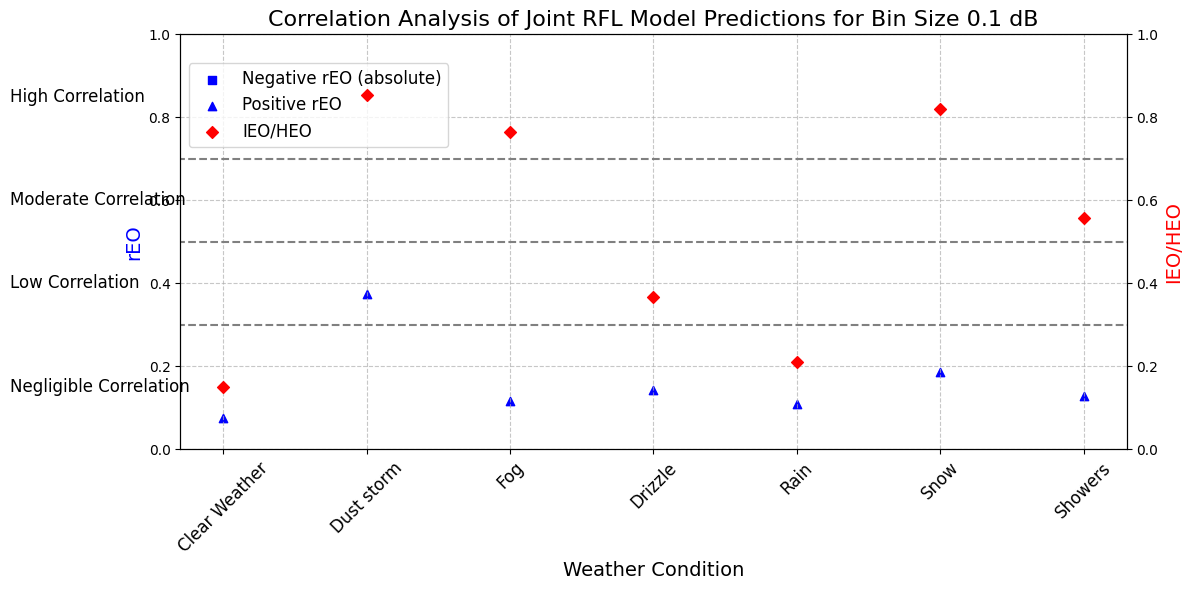

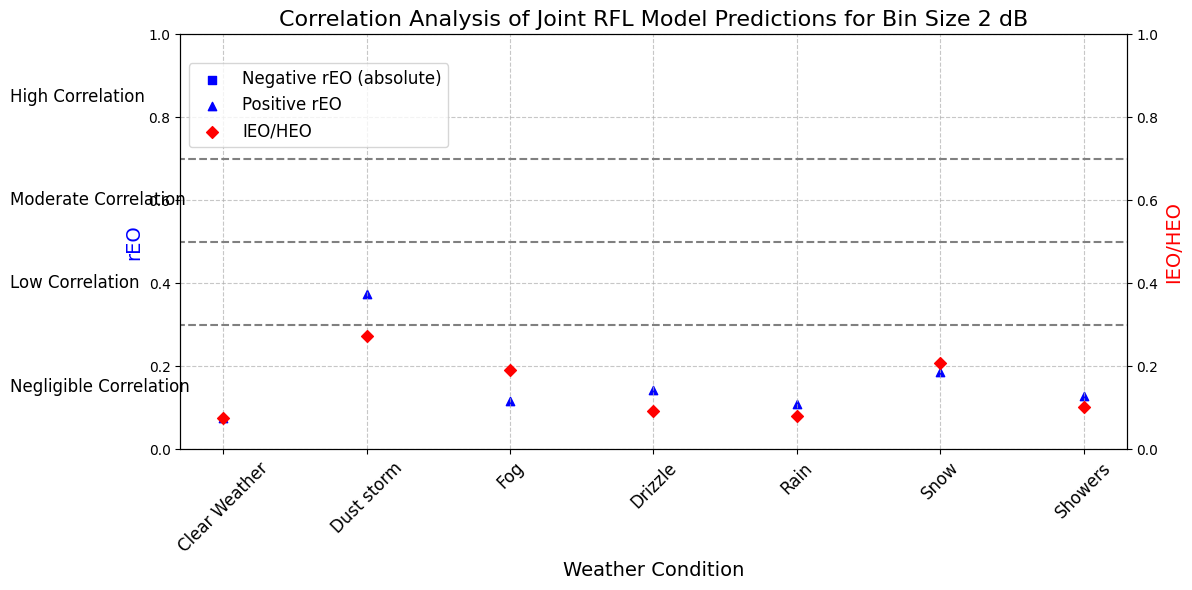

In [3]:
def plot_data_points(results_df, bin_size_label):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Create a secondary y-axis
    ax2 = ax1.twinx()

    # Separate the data for Negative rEO and Positive rEO
    negative_rEO = results_df[results_df['rEO'] < 0]
    positive_rEO = results_df[results_df['rEO'] >= 0]
    IEO_over_HEO = results_df['IEO/HEO']

    # Plot Negative rEO on ax1
    neg_scatter = ax1.scatter(negative_rEO.index, abs(negative_rEO['rEO']),
                              marker='s', color='blue', label='Negative rEO (absolute)')

    # Plot Positive rEO on ax1
    pos_scatter = ax1.scatter(positive_rEO.index, positive_rEO['rEO'],
                              marker='^', color='blue', label='Positive rEO')

    # Plot IEO/HEO on ax2
    IEO_scatter = ax2.scatter(results_df.index, IEO_over_HEO,
                               marker='D', color='red', label='IEO/HEO')

    # Set y-axis limits for both axes
    ax1.set_ylim(0, 1.0)
    ax2.set_ylim(0, 1.0)

    # Add horizontal dashed lines for correlation regions on the left y-axis
    correlation_thresholds = [0.3, 0.5, 0.7]
    correlation_labels = ['Negligible Correlation', 'Low Correlation', 'Moderate Correlation', 'High Correlation']

    for threshold in correlation_thresholds:
        ax1.axhline(y=threshold, xmin=-0.05, xmax=1, color='gray',
                   linestyle='--', linewidth=1.5)

    # Add labels to the correlation regions
    ax1.text(-0.18, 0.15, correlation_labels[0],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.4, correlation_labels[1],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.6, correlation_labels[2],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.85, correlation_labels[3],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 0.95), fontsize=12)

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['Weather'], rotation=45, fontsize=12)

    # Set axis labels and title
    ax1.set_xlabel("Weather Condition", fontsize=14)
    ax1.set_ylabel("rEO", fontsize=14, color='blue')
    ax2.set_ylabel("IEO/HEO", fontsize=14, color='red')
    ax1.set_title(f"Correlation Analysis of Joint RFL Model Predictions for Bin Size {bin_size_label}", fontsize=16)

    # Enable grid on primary axis
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Plot for Bin Size 0.1 dB
plot_data_points(M3_results_df_1, "0.1 dB")

# Plot for Bin Size 2 dB
plot_data_points(M3_results_df_2, "2 dB")

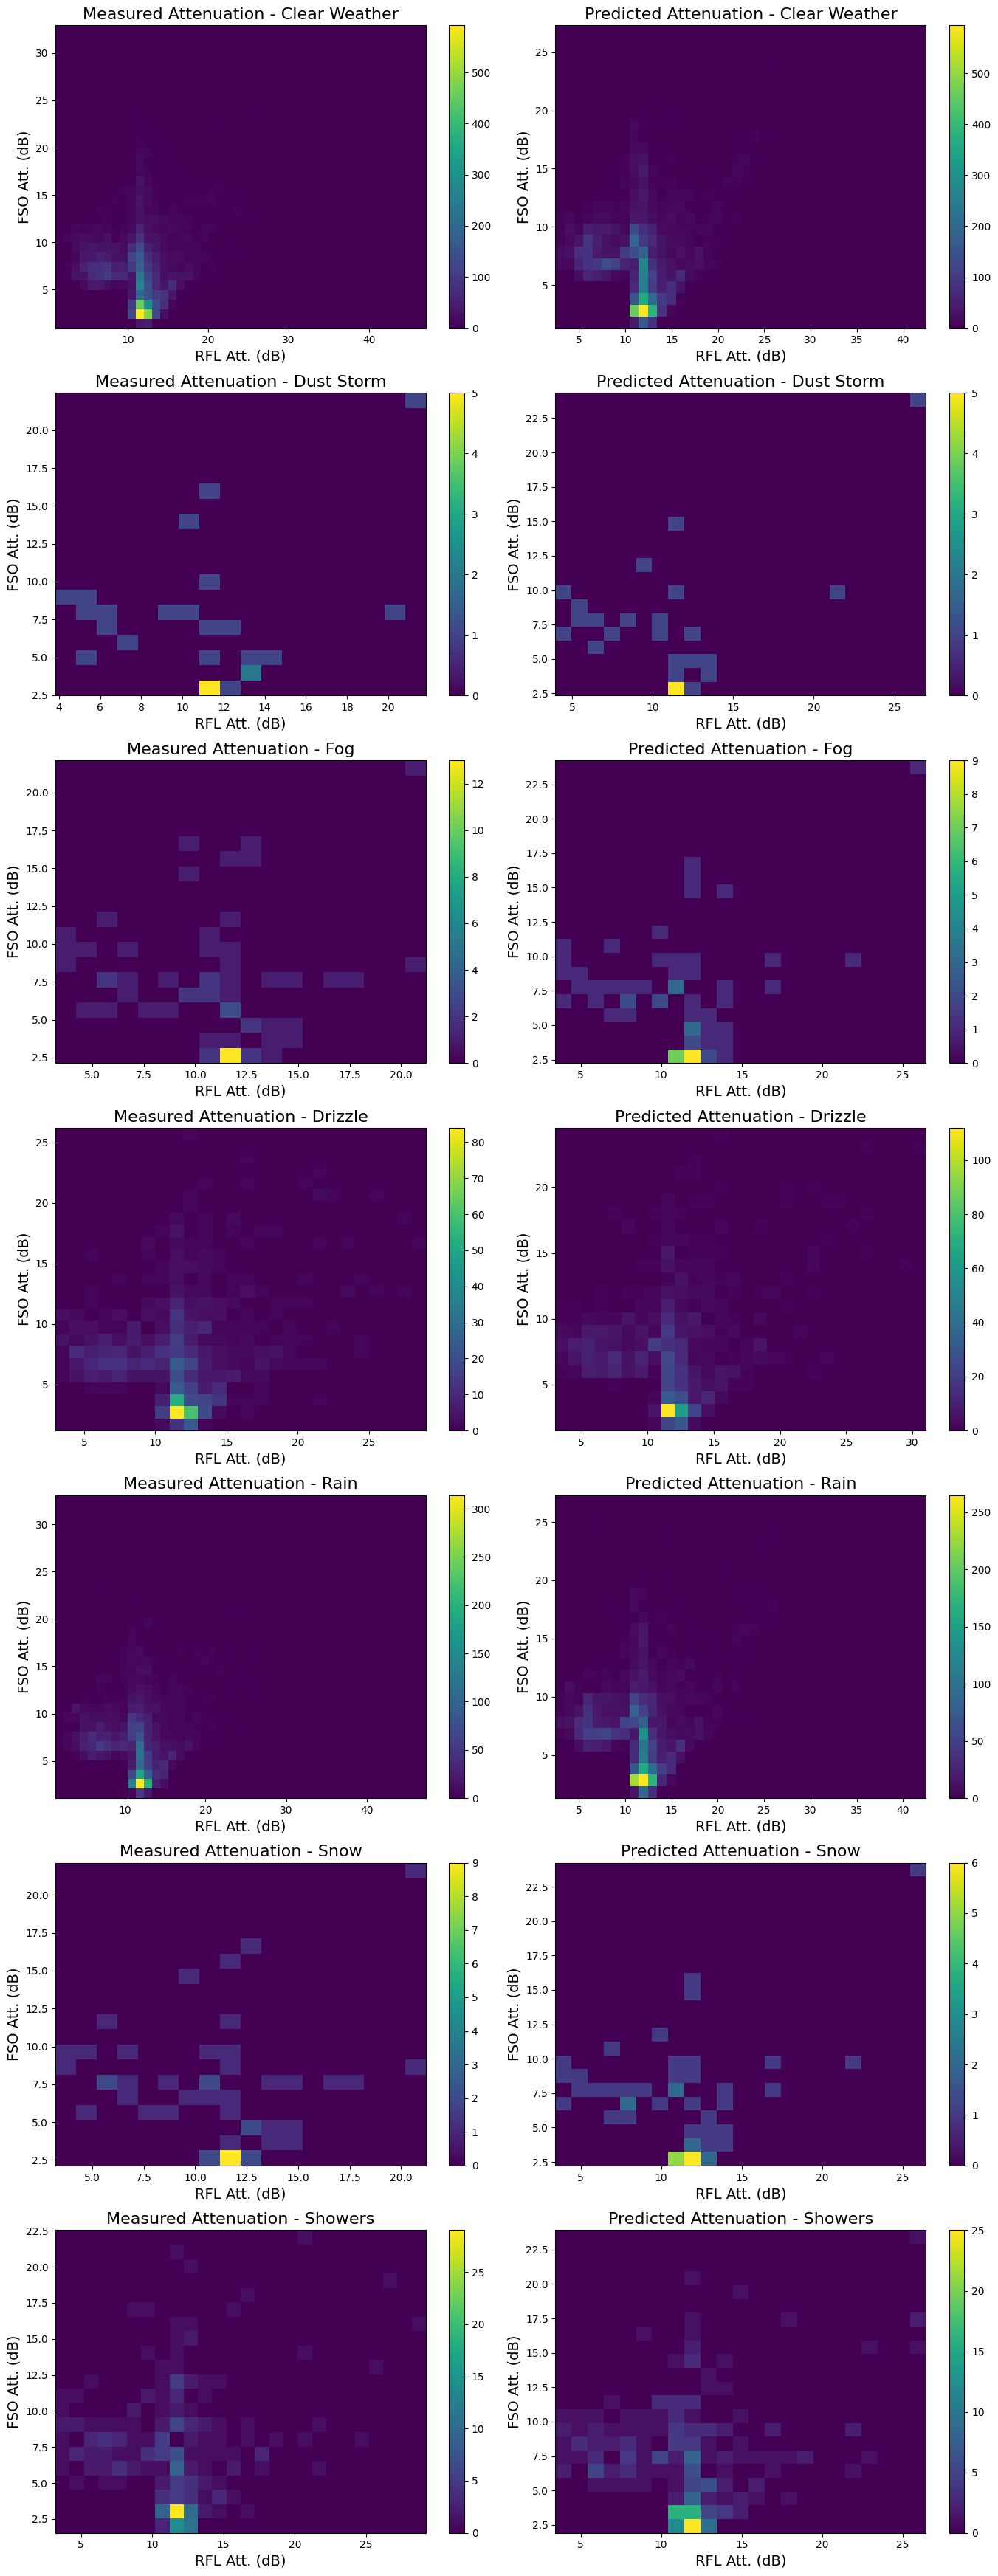

In [4]:
# Create a dictionary to hold test subsets based on SYNOP codes
test_rfl_subsets_method3 = {}
test_fso_subsets_method3 = {}
test_rfl_subsets = {}
test_fso_subsets = {}

synop_codes_order = [0, 3, 4, 5, 6, 7, 8]
synop_code_labels = ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']


# Convert NumPy arrays to pandas Series
predictions_rfl = pd.Series(pred_rfl_method3)
predictions_fso = pd.Series(pred_rfl_method3)

# Reset indices for consistency
X_test_fso = X_test_fso.reset_index(drop=True)
X_test_with_fso = X_test_with_fso.reset_index(drop=True)
y_test_rfl = y_test_rfl.reset_index(drop=True)
y_test_fso = y_test_fso.reset_index(drop=True)
predictions_rfl = predictions_rfl.reset_index(drop=True)
predictions_fso = predictions_fso.reset_index(drop=True)

# Populate subsets for RFL and FSO test data by SYNOP code
test_rfl_subsets = {
    code: X_test[X_test['SYNOPCode'] == code].reset_index(drop=True) for code in synop_codes_order
}
test_fso_subsets = {
    code: X_test_fso[X_test_fso['SYNOPCode'] == code].reset_index(drop=True) for code in synop_codes_order
}

# Splitting test datasets by SYNOP code
for synop_code in synop_codes_order:
    test_rfl_subsets_method3[synop_code] =X_test_with_fso[X_test_with_fso['SYNOPCode'] == synop_code].reset_index(drop=True)
    test_fso_subsets_method3[synop_code] = X_test_fso[X_test_fso['SYNOPCode'] == synop_code].reset_index(drop=True)

# Function to plot heatmap
def plot_heatmap(x_data, y_data, title, ax, x_label='RFL Att. (dB)', y_label='FSO Att. (dB)'):
    heatmap = ax.hist2d(x_data, y_data, bins=[np.arange(min(x_data), max(x_data) + 1), np.arange(min(y_data), max(y_data) + 1)], cmap='viridis')
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    plt.colorbar(heatmap[3], ax=ax)

fig, axs = plt.subplots(7, 2, figsize=(14, 35))  # 7 rows, 2 columns
axs = axs.flatten()  # Flatten the array for easy indexing

# Plotting code
for i, synop_code in enumerate(synop_codes_order):
    if not test_rfl_subsets[synop_code].empty:
        # Measured data
        x_measured = y_test_rfl.iloc[test_rfl_subsets[synop_code].index]
        y_measured = y_test_fso.iloc[test_fso_subsets[synop_code].index]

        # Predicted data
        x_predicted_method3 = predictions_rfl_method3[test_rfl_subsets_method3[synop_code].index.to_numpy()]
        y_predicted_method3 = predictions_test_fso[test_fso_subsets_method3[synop_code].index.to_numpy()]

        # Plot measured attenuation
        plot_heatmap(
            x_measured, y_measured,
            f'Measured Attenuation - {synop_code_labels[i]}',
            axs[i * 2]
        )

        # Plot predicted attenuation
        plot_heatmap(
            x_predicted_method3, y_predicted_method3,
            f'Predicted Attenuation - {synop_code_labels[i]}',
            axs[i * 2 + 1]
        )


plt.tight_layout()
plt.show()